In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from scipy.signal import savgol_filter
from tensorflow.keras.layers import LSTM, GRU, Dropout, Dense
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.models import Sequential
import math
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import tensorflow as tf

2024-02-14 17:45:47.344597: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-14 17:45:47.367974: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-14 17:45:47.367999: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-14 17:45:47.368943: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-14 17:45:47.373354: I tensorflow/core/platform/cpu_feature_guar

In [2]:
results_df = pd.DataFrame()

In [3]:
def load_csv_files(directory_path):
    SOH_THRESHOLD = 0.7
    data_dict = {}
    for filename in os.listdir(directory_path):
        if filename.endswith('.csv'):
            file_path = os.path.join(directory_path, filename)
            data = pd.read_csv(file_path)
            key = filename.split('.csv')[0]
            data_dict[key] = data['q'].values
            data_dict[key] = data_dict[key][data_dict[key]>SOH_THRESHOLD]
    return data_dict

qd_capacity_dict = load_csv_files('./new_sim/new_sim/')

# Split the battery IDs into training and testing sets
battery_ids = list(qd_capacity_dict.keys())
train_ids, test_ids = train_test_split(battery_ids, test_size=0.2, random_state=42)

# Initialize variables for training data
X_train = []
y_train = []
hops = 365
forecast_steps = 365*10

# Prepare training data using filtered and sliced battery data
for battery_id in train_ids:
    battery_data = qd_capacity_dict[battery_id]
    for i in range(hops, len(battery_data) - forecast_steps):
        X_train.append(battery_data[i - hops:i])
        y_train.append(battery_data[i:i + forecast_steps])

# Reshape for LSTM input
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# Prepare the testing data
X_test = []
y_test = []

for battery_id in test_ids:
    battery_data = np.array(qd_capacity_dict[battery_id])
    for i in range(hops, len(battery_data) - forecast_steps):
        X_test.append(battery_data[i - hops:i])
        y_test.append(battery_data[i:i + forecast_steps])

X_test, y_test = np.array(X_test), np.array(y_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [4]:
def make_LSTM():
    # Build the LSTM model
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50))
    model.add(Dropout(0.2))
    model.add(Dense(forecast_steps))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

def make_GRU():
    model = Sequential()
    model.add(GRU(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
    model.add(Dropout(0.2))
    model.add(GRU(units=50))
    model.add(Dropout(0.2))
    model.add(Dense(forecast_steps))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

def make_1DCNN(kernel_size):
    # Build the RNN model
    model = Sequential()
    model.add(Conv1D(filters=32, kernel_size=kernel_size, activation='relu', input_shape=(X_train.shape[1], 1)))
    model.add(MaxPooling1D(pool_size=3))
    model.add(Conv1D(filters=64, kernel_size=kernel_size, activation='relu', input_shape=(X_train.shape[1], 1)))
    model.add(MaxPooling1D(pool_size=3))
    model.add(Flatten())
    model.add(Dense(50, activation='relu'))
    model.add(Dense(forecast_steps))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [5]:
def make_multistep_forecasts(model):
    rmse_multiforecast_list = []
    CUT_OFF = 365*5

    # Prediction code
    for i, battery_id in enumerate(test_ids):
        battery_data = np.array(qd_capacity_dict[battery_id]).reshape(-1, 1)
        input_sequence = battery_data[:hops, 0]

        predictions = []
        cycle_count = 0  # Initialize cycle count

        while cycle_count < (CUT_OFF - hops):
            model_input = np.reshape(input_sequence, (1, -1, 1))
            predicted_cycles = model.predict(model_input, verbose=0).flatten()

            predictions.extend(predicted_cycles)
            input_sequence = np.append(input_sequence[len(predicted_cycles):], predicted_cycles)

            cycle_count += len(predicted_cycles)

        combined_capacity = np.concatenate((battery_data[:hops, 0], predictions))

        cycle_indices = np.arange(1, len(combined_capacity) + 1)

        final_y = battery_data[hops:CUT_OFF, 0]
        rmse_multiforecast = np.sqrt(mean_squared_error(final_y, predictions[:len(final_y)]))
        rmse_multiforecast_list.append(rmse_multiforecast)

        # Plotting
        plt.figure(figsize=(10, 5))
        plt.plot(cycle_indices[:hops], battery_data[:hops, 0], label='Initial Cycles', alpha=0.7)
        plt.plot(cycle_indices[hops:CUT_OFF], combined_capacity[hops:CUT_OFF], label='Predicted Capacity', alpha=0.7, linestyle='--', color='orange')
        plt.plot(battery_data[:CUT_OFF, 0], label='Actual Capacity (500 Days)', alpha=0.7, linestyle='--', color='green')
        plt.title(f'Battery {battery_id} Capacity Prediction for 500 Days')
        plt.xlabel('Cycles')
        plt.ylabel('Capacity')
        plt.legend()
        plt.show()

    return rmse_multiforecast_list

In [5]:
# Train the model
EPOCHS = 50
batch_size = 32
num_samples = len(X_train) # Total number of samples in your dataset

# Calculate the number of batches per epoch
batches_per_epoch = num_samples / batch_size

# Calculate save frequency in terms of batches
epoch_save_freq = 10
save_freq = int(batches_per_epoch * epoch_save_freq)

models = [('LSTM', make_LSTM),
        #   ('GRU', make_GRU)
          ]

trained_models = {}
preds_dict = {}
for model_info in models:
    model_name = model_info[0]
    model_maker = model_info[1]
    if '1DCNN' in model_name:
        kernel_size = int(model_name[-1])
        model = model_maker(kernel_size)
        folder_name = model_name
    else:
        model = model_maker()
        folder_name = model_name
    # Define the checkpoint directory and file names
    checkpoint_path = "checkpoints_ten_years/"+f"{folder_name}"+"/cp-{epoch:04d}.ckpt"
    checkpoint_dir = os.path.dirname(checkpoint_path)

    # Create a callback that saves the model's weights every 50 epochs
    cp_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_path, 
        verbose=1, 
        save_weights_only=True,
        save_freq=save_freq)


    model.fit(X_train, y_train, epochs=EPOCHS, batch_size=batch_size, callbacks=[cp_callback])
    trained_models[model_name] = model

    y_pred = model.predict(X_train)
    rmse_train = np.sqrt(mean_squared_error(y_pred, y_train))
    results_df.loc[model_name, "train"] = rmse_train

    y_pred = model.predict(X_test)
    rmse_test = np.sqrt(mean_squared_error(y_pred, y_test))
    results_df.loc[model_name, "test"] = rmse_test

2024-02-14 17:46:15.125958: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-14 17:46:15.146075: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-14 17:46:15.146191: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Epoch 1/50


2024-02-14 17:46:20.606404: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-02-14 17:46:21.182617: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fbca41b2920 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-02-14 17:46:21.182631: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2024-02-14 17:46:21.186828: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1707900381.246248   80173 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1005/7602 [==>...........................] - ETA: 2:00 - loss: nan

KeyboardInterrupt: 

# Checkpoint 5 years

In [7]:
# Load saved model
forecast_steps = 365*5
models = [('LSTM', make_LSTM, 'checkpoints_five_years/BEST_LSTM_160EPOCHS/cp-0160.ckpt'),
          ('GRU', make_GRU, 'checkpoints_five_years/GRU/cp-0050.ckpt'),
        #   ('1DCNN3', make_1DCNN, 'checkpoints_five_years/1DCNN/cp-0050.ckpt'),
          ]

# models = [('1DCNN3', make_1DCNN, 'checkpoints_ten_years/1DCNN3/cp-0250.ckpt'),]

trained_models = {}
preds_dict = {}
for model_info in models:
    model_name = model_info[0]
    model_maker = model_info[1]
    checkpoint_path = model_info[2]
    if '1DCNN' in model_name:
        kernel_size = int(model_name[-1])
        model = model_maker(kernel_size)
        folder_name = '1DCNN'
    else:
        model = model_maker()
        folder_name = model_name
    model.load_weights(checkpoint_path)
    trained_models[model_name] = model

In [8]:
results_df = pd.DataFrame()

In [9]:
def make_multistep_forecasts(model, hops, dead_input_length, cut_off):
    rmse_multiforecast_list = []

    # Setting up the figure and axes for a 5x5 grid of plots
    fig, axes = plt.subplots(5, 5, figsize=(15, 15))

    # Prediction code
    for index, battery_id in enumerate(test_ids):
        battery_data = np.array(qd_capacity_dict[battery_id][:cut_off]).reshape(-1, 1)
        input_sequence = battery_data[dead_input_length:(dead_input_length+hops), 0]

        predictions = []
        cycle_count = 0  # Initialize cycle count

        while cycle_count < (cut_off - hops):
            model_input = np.reshape(input_sequence, (1, -1, 1))
            predicted_cycles = model.predict(model_input, verbose=0).flatten()

            predictions.extend(predicted_cycles)
            input_sequence = np.append(input_sequence[len(predicted_cycles):], predicted_cycles)

            cycle_count += len(predicted_cycles)

        combined_capacity = np.concatenate((battery_data[:(dead_input_length+hops), 0], predictions))

        cycle_indices = np.arange(1, len(combined_capacity) + 1)

        final_y = battery_data[(dead_input_length+hops):cut_off, 0]
        rmse_multiforecast = np.sqrt(mean_squared_error(final_y, predictions[:len(final_y)]))
        rmse_multiforecast_list.append(rmse_multiforecast)

        # Plotting
        # plt.figure(figsize=(10, 5))
        # plt.plot(cycle_indices[:(dead_input_length+hops)], battery_data[:(dead_input_length+hops), 0], label='Initial Cycles', alpha=0.7)
        # plt.plot(cycle_indices[(dead_input_length+hops):cut_off], combined_capacity[(dead_input_length+hops):cut_off], label='Predicted Capacity', alpha=0.7, linestyle='--', color='orange')
        # plt.plot(battery_data[:cut_off, 0], label=f'Actual Capacity ({cut_off} Days)', alpha=0.7, linestyle='--', color='green')
        # plt.title(f'Battery {battery_id} Capacity Prediction for {cut_off} Days')
        # plt.xlabel('Days')
        # plt.ylabel('Capacity')
        # plt.legend()
        # plt.show()

        # Given a single index from 0 to 24, we need to transform it into a pair of indexes (i, j) for a 5x5 grid

        # Initialize an empty list to hold the transformed indexes
        transformed_indexes = []

        # Convert the single index to a pair (i, j) for a 5x5 grid
        i = index // 5
        j = index % 5

        # Generating random data for each subplot
        ax = axes[i, j]
        x = cycle_indices[:(dead_input_length+hops)]
        y = battery_data[:(dead_input_length+hops), 0]
        ax.plot(x, y, label='Initial Cycles', alpha=0.7)
        x = cycle_indices[(dead_input_length+hops):cut_off]
        y = combined_capacity[(dead_input_length+hops):cut_off]
        ax.plot(x, y, label='Predicted Capacity', alpha=0.7, linestyle='--', color='orange')
        x = range(cut_off)
        y = battery_data[:cut_off, 0]
        ax.plot(x, y, label=f'Actual Capacity ({cut_off} Days)', alpha=0.7, linestyle='--', color='green')
        ax.set_title(f'Battery {battery_id} \nCapacity Prediction for {cut_off} Days')

    plt.tight_layout()
    plt.show()


    return rmse_multiforecast_list

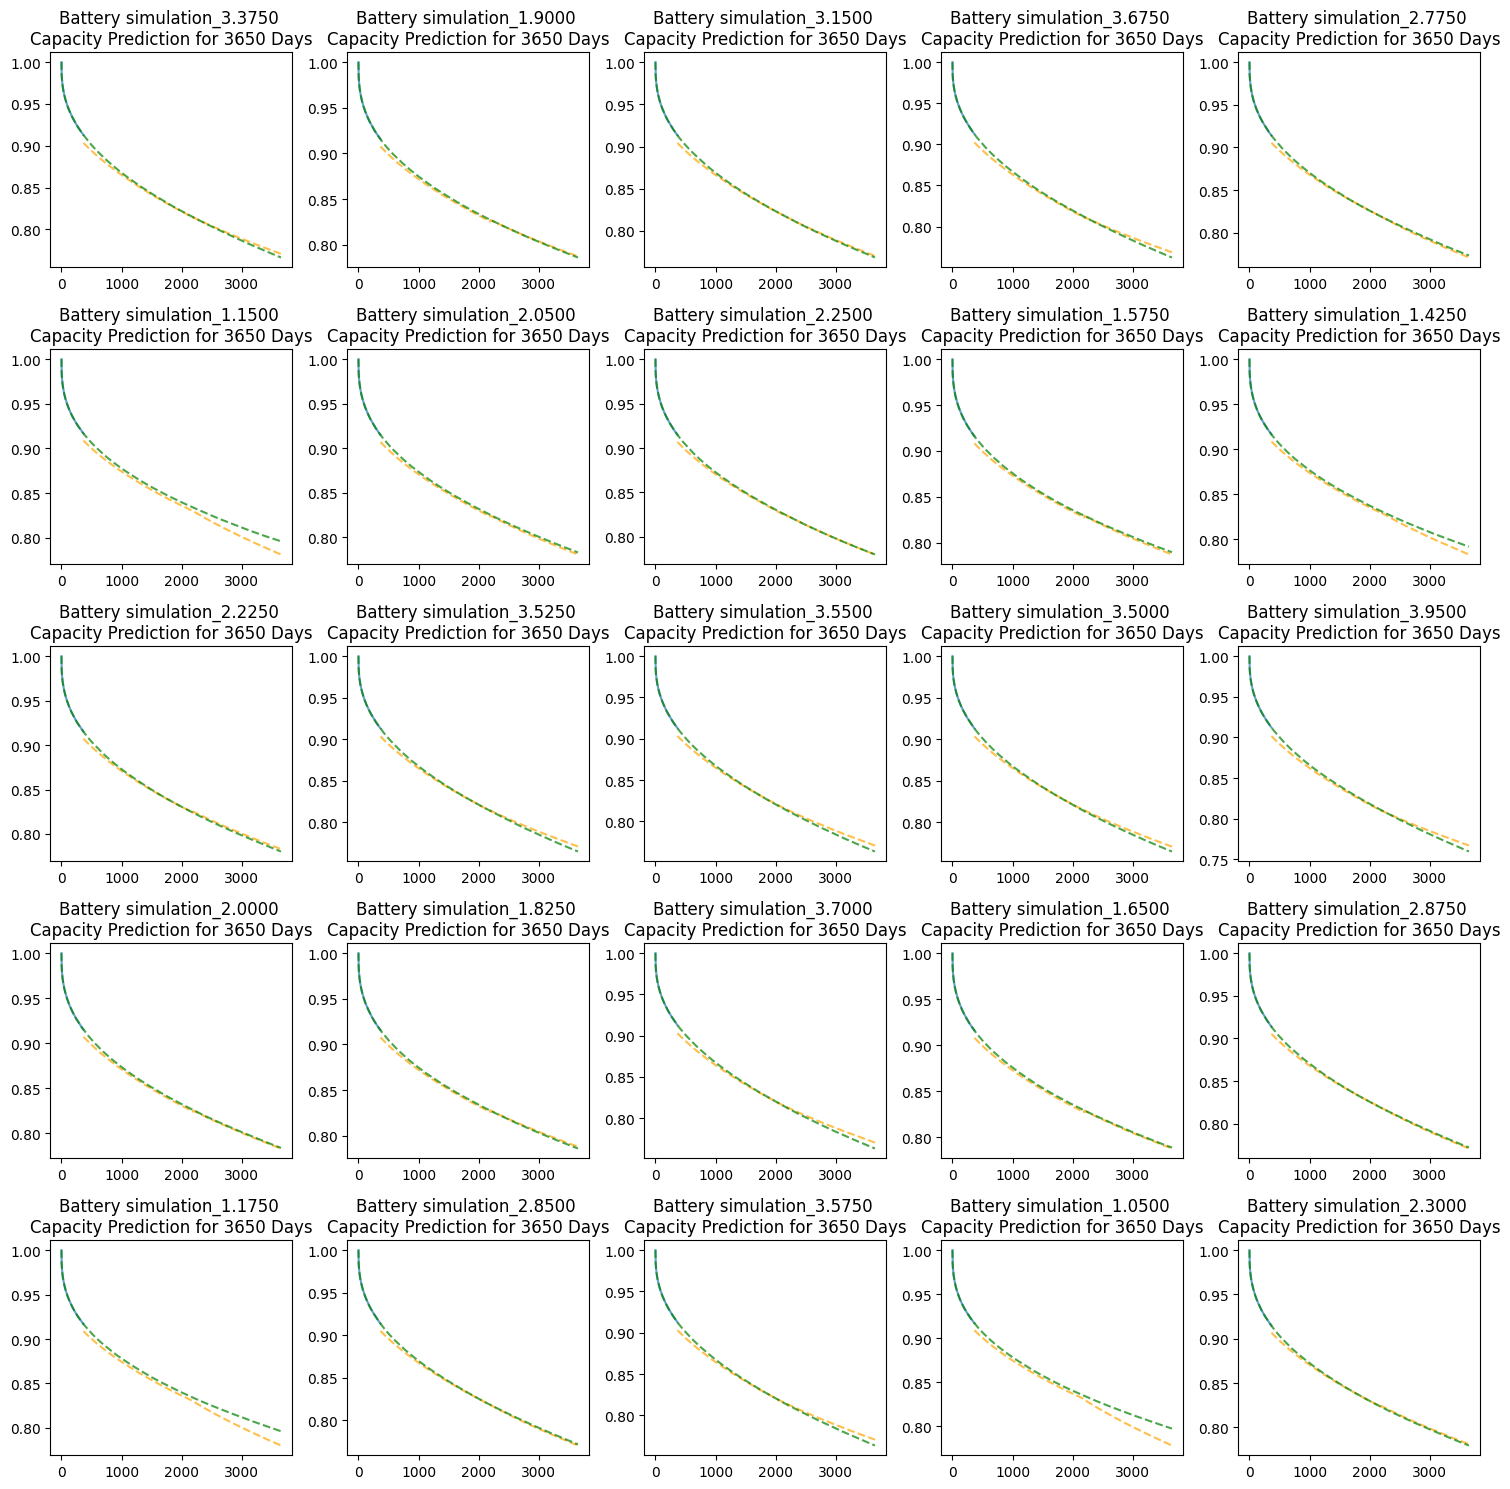

In [10]:
MODEL_NAME = 'LSTM'
model = trained_models[MODEL_NAME]
hops = 365
cut_off = 365*10
dead_input_lengths = [0]
for dead_input_length in dead_input_lengths:
    rmse_multiforecast_list = make_multistep_forecasts(model, hops, dead_input_length, cut_off)
    results_df.loc[MODEL_NAME, f"multi_forecast_dead_input_length{dead_input_length}"] = np.mean(rmse_multiforecast_list)

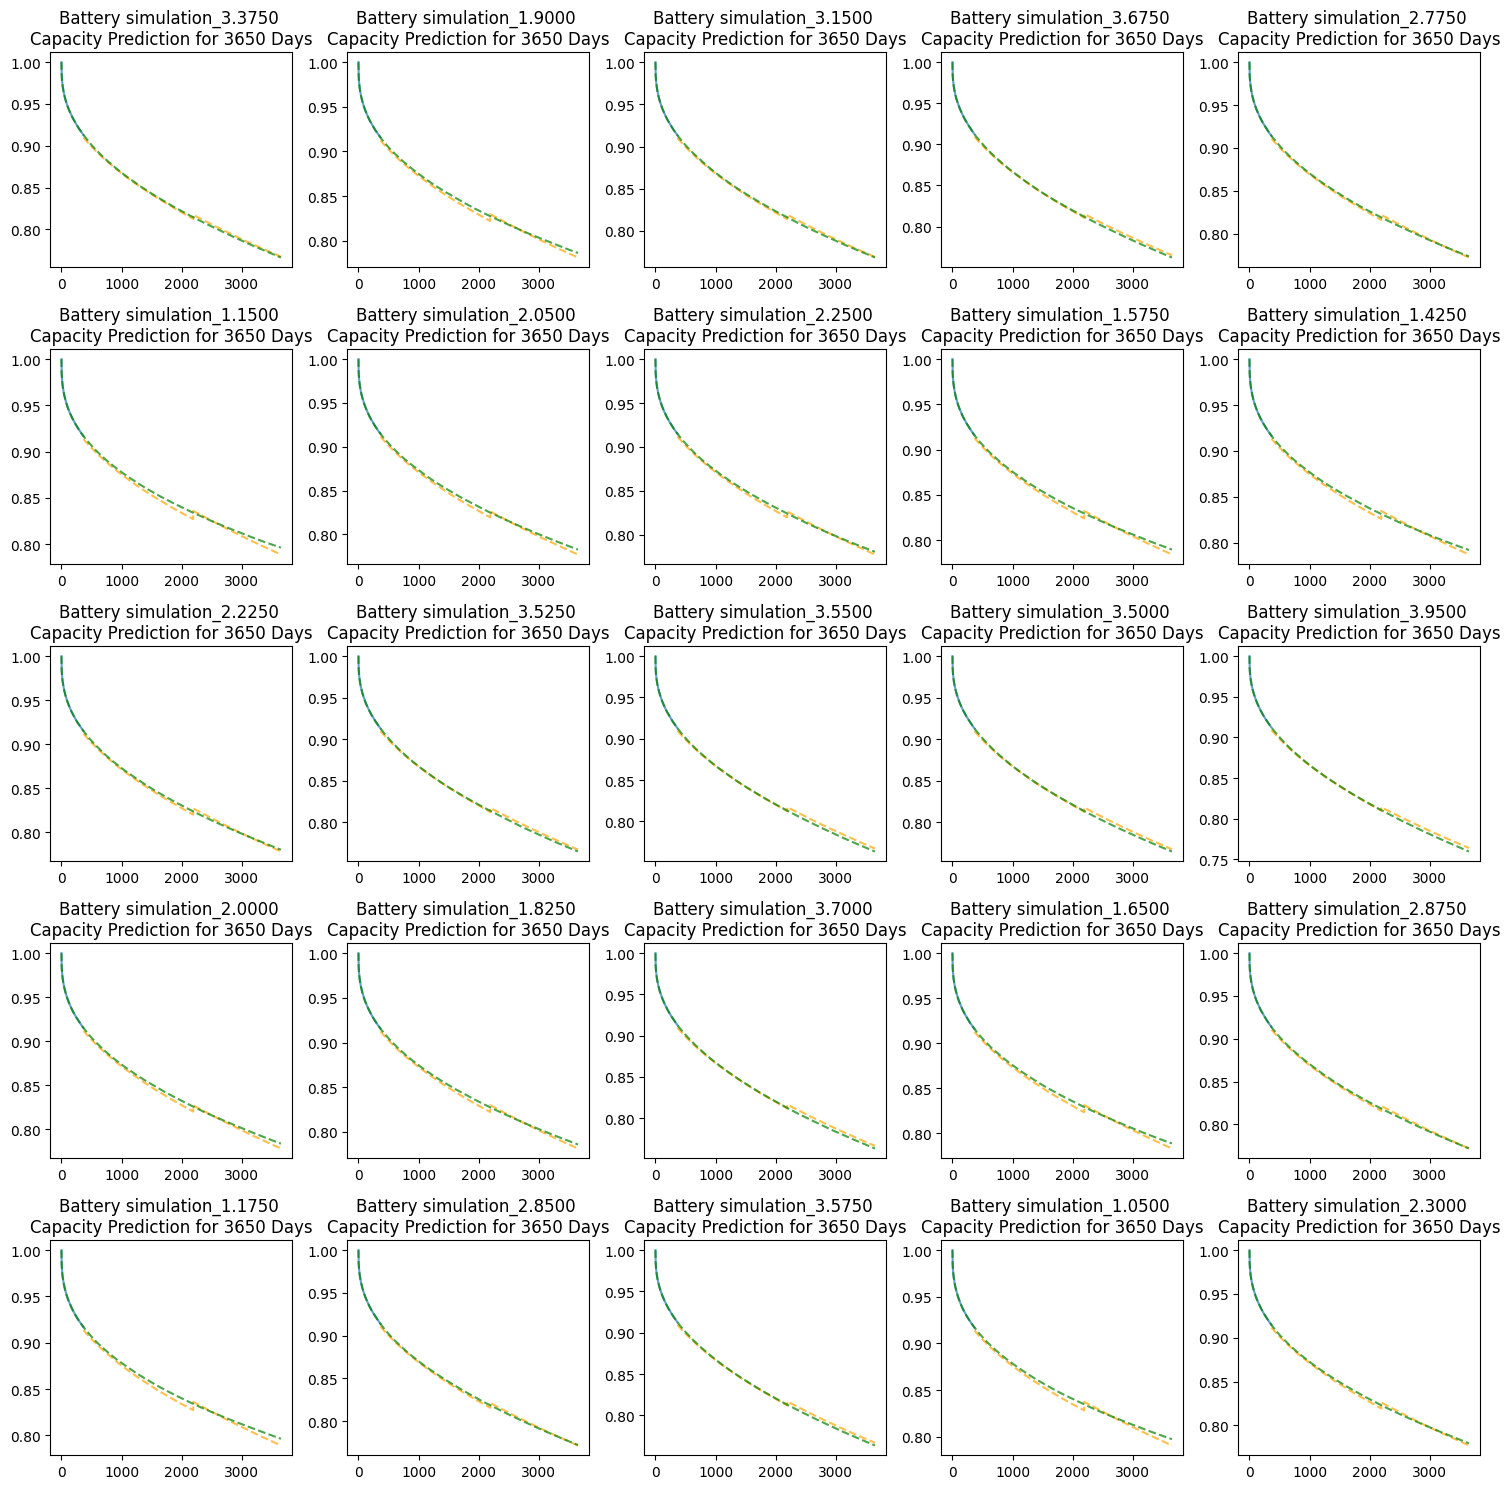

In [12]:
MODEL_NAME = 'GRU'
model = trained_models[MODEL_NAME]
hops = 365
cut_off = 365*10
dead_input_lengths = [0]
for dead_input_length in dead_input_lengths:
    rmse_multiforecast_list = make_multistep_forecasts(model, hops, dead_input_length, cut_off)
    results_df.loc[MODEL_NAME, f"multi_forecast_dead_input_length{dead_input_length}"] = np.mean(rmse_multiforecast_list)

In [13]:
results_df

,multi_forecast_dead_input_length0
LSTM,0.003673
GRU,0.002626


# Checkpoint 10 years

In [14]:
# Load saved model
forecast_steps = 365*10

models = [('1DCNN3', make_1DCNN, 'checkpoints_ten_years/1DCNN3/cp-0250.ckpt'),]

trained_models = {}
preds_dict = {}
for model_info in models:
    model_name = model_info[0]
    model_maker = model_info[1]
    checkpoint_path = model_info[2]
    if '1DCNN' in model_name:
        kernel_size = int(model_name[-1])
        model = model_maker(kernel_size)
        folder_name = '1DCNN'
    else:
        model = model_maker()
        folder_name = model_name
    model.load_weights(checkpoint_path)
    trained_models[model_name] = model

2024-02-14 17:48:56.453590: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


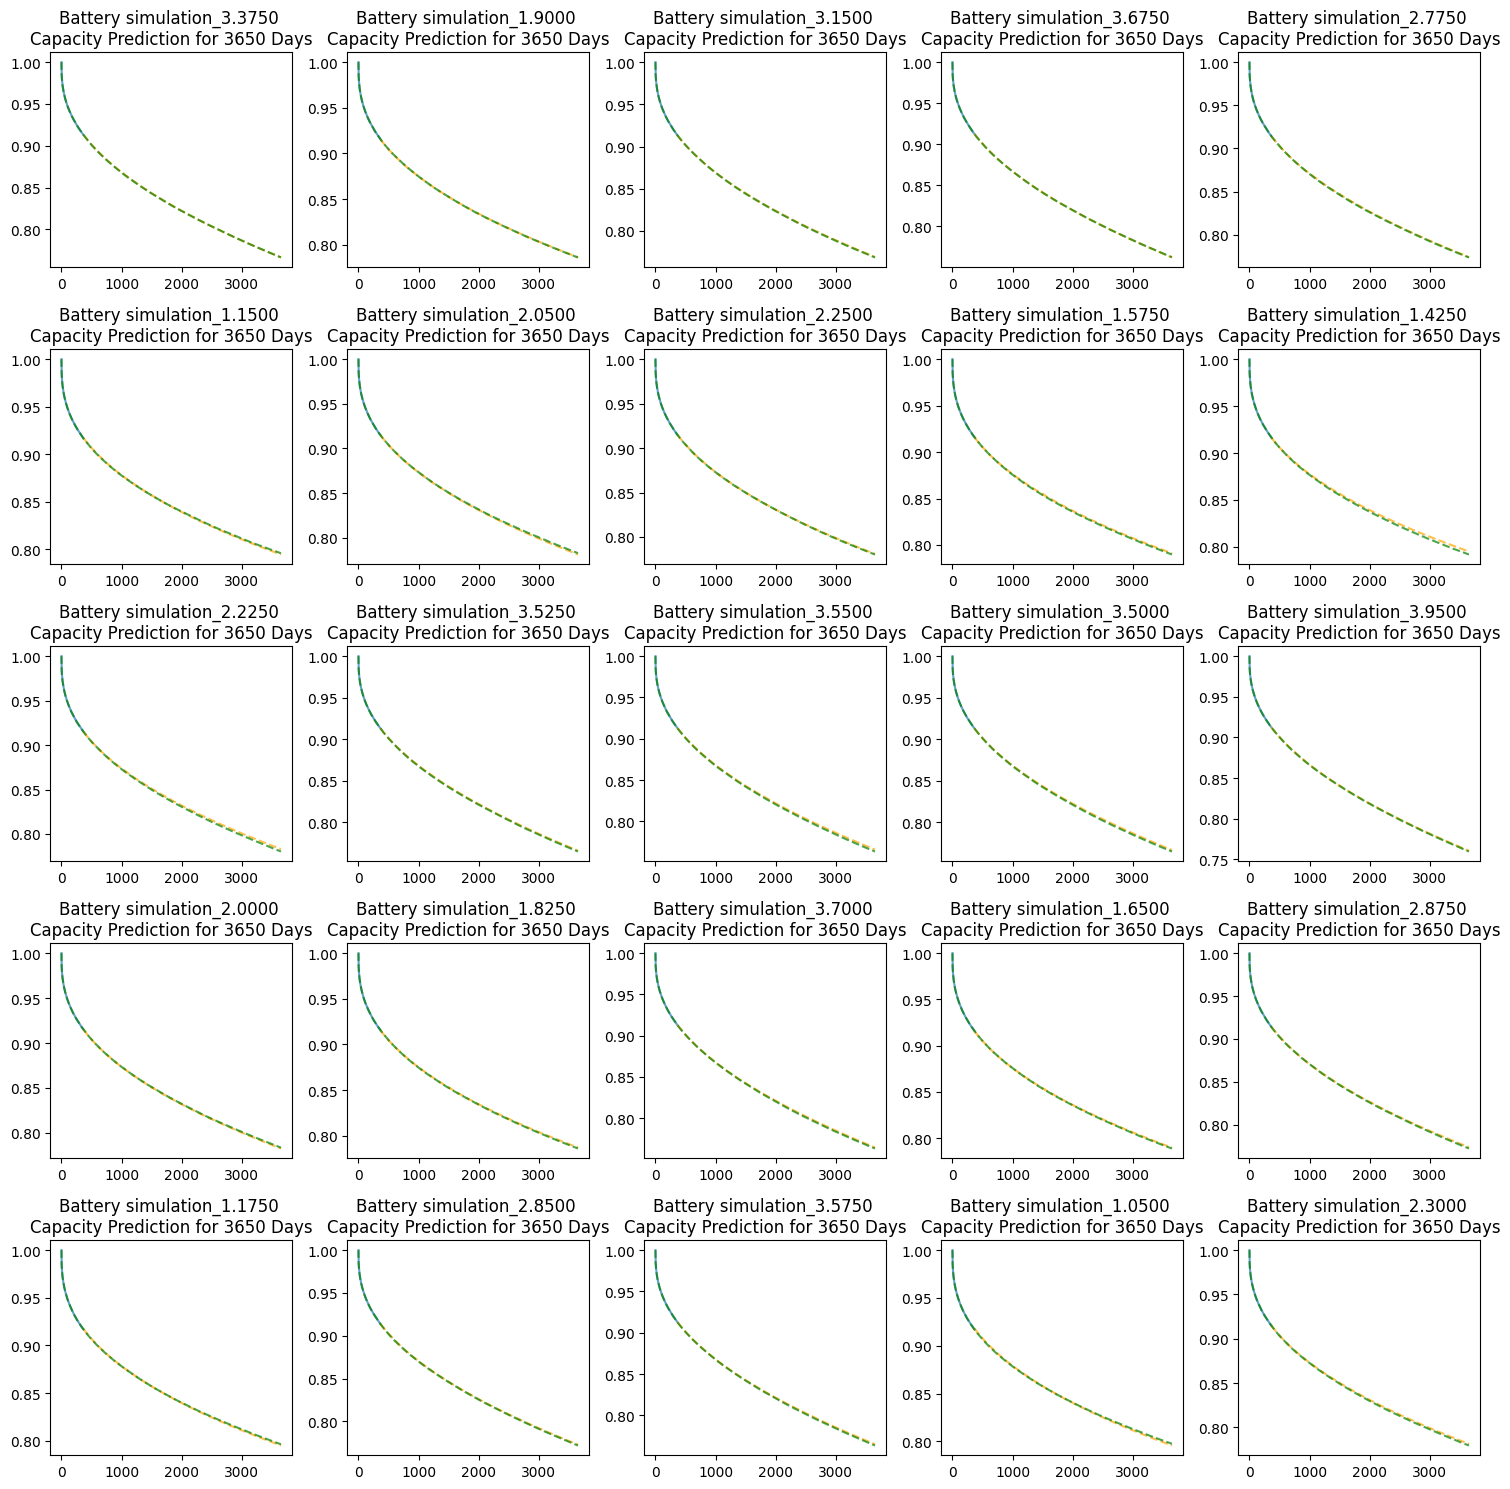

In [15]:
MODEL_NAME = '1DCNN3'
model = trained_models[MODEL_NAME]
hops = 365
cut_off = 365*10
dead_input_lengths = [0]
for dead_input_length in dead_input_lengths:
    rmse_multiforecast_list = make_multistep_forecasts(model, hops, dead_input_length, cut_off)
    results_df.loc[MODEL_NAME, f"multi_forecast_dead_input_length{dead_input_length}"] = np.mean(rmse_multiforecast_list)

In [16]:
results_df

,multi_forecast_dead_input_length0
LSTM,0.003673
GRU,0.002626
1DCNN3,0.000793
